In [1]:
import os
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

True

In [6]:
import uuid
import asyncio
from typing import TypedDict, List, Annotated, Optional, Dict, Any
from dataclasses import dataclass
from IPython.display import display, HTML
import pandas as pd
import numpy as np

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel

# 1. 1년 데이터용 재무 데이터 모델
@dataclass
class RealFinancialData:
    """실제 재무제표 데이터 (1년 기준)"""
    corp_name: str  # 기업명
    market_type: str  # 시장구분 (KOSPI, KOSDAQ 등)
    industry_name: str  # 업종명
    year: int  # 연도

    # 손익계산서
    revenue: float  # 매출액
    operating_income: float  # 영업이익
    net_income: float  # 당기순이익

    # 재무상태표
    total_assets: float  # 총자산
    total_liabilities: float  # 총부채
    total_equity: float  # 자본총계
    capital_stock: float  # 자본금
    interest_bearing_debt: float  # 이자발생부채

    # 현금흐름표
    operating_cash_flow: float  # 영업활동현금흐름

    # 이미 계산된 재무비율들
    debt_ratio: float  # 부채비율
    roa: float  # ROA
    roe: float  # ROE
    asset_turnover: float  # 매출총자산회전율
    interest_to_asset: float  # 이자총자산비율
    interest_to_revenue: float  # 이자매출비율
    cash_to_interest: float  # 현금흐름대비이자
    interest_to_cash: float  # 이자대비현금흐름
    log_total_assets: float  # 로그총자산
    log_total_liabilities: float  # 로그총부채

@dataclass
class CreditRating:
    """신용등급 정보"""
    rating_agency: str  # 평가기관
    current_rating: str  # 현재 등급
    previous_rating: str  # 이전 등급
    rating_date: str  # 등급 부여일
    outlook: str  # 전망

@dataclass
class Section:
    name: str
    description: str
    requires_calculation: bool  # 추가 재무비율 계산 필요 여부
    requires_research: bool  # 웹 검색 필요 여부
    content: str = ""
    char_limit: int = 0  # 글자 수 제한

# 2. 상태 정의 (단일 연도 기준)
class CreditAnalysisState(TypedDict):
    company_data: RealFinancialData  # 단일 연도 데이터
    credit_ratings: List[CreditRating]
    sections: List[Section]
    additional_ratios: Dict[str, float]  # 추가 계산된 비율들
    summary_card: str  # 1페이지 요약 카드
    detailed_report: str  # 상세 풀 리포트
    current_section_index: int
    all_analysis_done: bool
    peer_companies: List[str]

# 3. 추가 재무비율 계산기 (단일연도용)
class AdditionalRatioCalculator:
    """기존 재무비율 외 추가 비율 계산"""

    @staticmethod
    def calculate_liquidity_ratios(data: RealFinancialData) -> Dict[str, float]:
        """유동성 비율 (추정 계산)"""
        ratios = {}

        # 유동자산/유동부채가 없으므로 추정
        estimated_current_assets = data.total_assets * 0.5  # 50% 추정
        estimated_current_liabilities = data.total_liabilities * 0.7  # 70% 추정

        if estimated_current_liabilities > 0:
            ratios['estimated_current_ratio'] = estimated_current_assets / estimated_current_liabilities

        # 현금비율 (영업현금흐름 기반 추정)
        if estimated_current_liabilities > 0:
            ratios['cash_flow_ratio'] = data.operating_cash_flow / estimated_current_liabilities

        return ratios

    @staticmethod
    def calculate_coverage_ratios(data: RealFinancialData) -> Dict[str, float]:
        """커버리지 비율"""
        ratios = {}

        # 이자보상배수 (이자비용 = 이자매출비율 × 매출액)
        interest_expense = data.interest_to_revenue * data.revenue / 100
        if interest_expense > 0:
            ratios['interest_coverage_ratio'] = data.operating_income / interest_expense
            ratios['ebitda_interest_coverage'] = (data.operating_income * 1.3) / interest_expense  # EBITDA 추정

        # 현금흐름 이자보상배수
        if interest_expense > 0:
            ratios['cash_interest_coverage'] = data.operating_cash_flow / interest_expense

        return ratios

    @staticmethod
    def calculate_all_additional_ratios(data: RealFinancialData) -> Dict[str, float]:
        """모든 추가 재무비율 계산"""
        all_ratios = {}

        liquidity = AdditionalRatioCalculator.calculate_liquidity_ratios(data)
        coverage = AdditionalRatioCalculator.calculate_coverage_ratios(data)

        all_ratios.update(liquidity)
        all_ratios.update(coverage)

        return all_ratios

# 4. HTML 템플릿
def get_html_template():
    """HTML 보고서 템플릿"""
    return """
    <!DOCTYPE html>
    <html lang="ko">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>{company_name} 신용분석보고서</title>
        <style>
            body {{
                font-family: 'Malgun Gothic', 'Apple SD Gothic Neo', sans-serif;
                line-height: 1.6;
                color: #333;
                max-width: 1200px;
                margin: 0 auto;
                padding: 20px;
                background-color: #f8f9fa;
            }}
            .header {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 30px;
                border-radius: 10px;
                margin-bottom: 30px;
                text-align: center;
            }}
            .header h1 {{
                margin: 0;
                font-size: 2.5em;
                font-weight: bold;
            }}
            .header .subtitle {{
                font-size: 1.2em;
                margin-top: 10px;
                opacity: 0.9;
            }}
            .summary-card {{
                background: white;
                border-radius: 10px;
                padding: 30px;
                margin-bottom: 30px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
                border-left: 5px solid #667eea;
            }}
            .detailed-report {{
                background: white;
                border-radius: 10px;
                padding: 30px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            }}
            h2 {{
                color: #2c3e50;
                border-bottom: 3px solid #667eea;
                padding-bottom: 10px;
                margin-top: 30px;
            }}
            h3 {{
                color: #34495e;
                margin-top: 25px;
            }}
            table {{
                width: 100%;
                border-collapse: collapse;
                margin: 20px 0;
                background: white;
            }}
            th, td {{
                border: 1px solid #ddd;
                padding: 12px;
                text-align: center;
            }}
            th {{
                background-color: #667eea;
                color: white;
                font-weight: bold;
            }}
            tr:nth-child(even) {{
                background-color: #f2f2f2;
            }}
            .rating-badge {{
                display: inline-block;
                background: #28a745;
                color: white;
                padding: 5px 15px;
                border-radius: 20px;
                font-weight: bold;
                font-size: 1.1em;
            }}
            .keyword {{
                display: inline-block;
                background: #17a2b8;
                color: white;
                padding: 3px 10px;
                border-radius: 15px;
                margin: 2px;
                font-size: 0.9em;
            }}
            .metric {{
                background: #e9ecef;
                padding: 15px;
                border-radius: 5px;
                margin: 10px 0;
            }}
            .metric strong {{
                color: #495057;
            }}
            .footer {{
                text-align: center;
                margin-top: 40px;
                padding: 20px;
                color: #6c757d;
                font-size: 0.9em;
            }}
            .section {{
                margin-bottom: 40px;
            }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>{company_name} 신용분석보고서</h1>
            <div class="subtitle">{industry_name} | {market_type} | {year}년 기준</div>
        </div>

        <div class="summary-card">
            {summary_content}
        </div>

        <div class="detailed-report">
            {detailed_content}
        </div>

        <div class="footer">
            <p>본 보고서는 제공된 재무 데이터를 기반으로 AI가 생성한 분석 보고서입니다.</p>
            <p>보고서 생성일: {generation_date}</p>
        </div>
    </body>
    </html>
    """

# 5. HTML 변환 함수
def markdown_to_html(markdown_text: str) -> str:
    """마크다운을 HTML로 변환"""
    html = markdown_text

    # 헤더 변환
    html = html.replace('## ', '<h2>').replace('\n\n', '</h2>\n\n')
    html = html.replace('### ', '<h3>').replace('\n\n', '</h3>\n\n')

    # 테이블 변환 (간단히)
    lines = html.split('\n')
    new_lines = []
    in_table = False

    for line in lines:
        if '|' in line and not line.strip().startswith('#'):
            if not in_table:
                new_lines.append('<table>')
                in_table = True

            if '---' in line:
                continue

            cells = [cell.strip() for cell in line.split('|') if cell.strip()]
            if len(cells) > 0:
                if '**' in line:  # 헤더 행
                    row = '<tr>' + ''.join([f'<th>{cell.replace("**", "")}</th>' for cell in cells]) + '</tr>'
                else:
                    row = '<tr>' + ''.join([f'<td>{cell}</td>' for cell in cells]) + '</tr>'
                new_lines.append(row)
        else:
            if in_table:
                new_lines.append('</table>')
                in_table = False
            new_lines.append(line)

    if in_table:
        new_lines.append('</table>')

    html = '\n'.join(new_lines)

    # 강조 텍스트
    html = html.replace('**', '<strong>').replace('**', '</strong>')
    html = html.replace('*', '<em>').replace('*', '</em>')

    # 문단 변환
    paragraphs = html.split('\n\n')
    html_paragraphs = []

    for p in paragraphs:
        p = p.strip()
        if p and not p.startswith('<'):
            html_paragraphs.append(f'<p>{p}</p>')
        else:
            html_paragraphs.append(p)

    return '\n'.join(html_paragraphs)

# 6. 프롬프트 템플릿 (단일연도용)
SUMMARY_CARD_PROMPT = """
기업명: {company_name}
업종: {industry_name}
시장구분: {market_type}
분석연도: {year}

다음 재무 데이터와 신용등급 정보를 바탕으로 **1페이지 요약 카드형 보고서**를 작성해주세요:

재무 데이터:
{financial_data}

신용등급 정보:
{credit_ratings}

다음 형식으로 작성해주세요:

## 📘 신용분석 요약 카드

**기업명**: {company_name}
**평가일자**: {evaluation_date}
**신용등급**: [등급]/[전망] (예: AA+/Stable)

**현재 등급 요약** (100자 이내):
[등급의 핵심 의미와 배경]

**주요 강점 키워드** (3개 이내):
• [강점1] • [강점2] • [강점3]

**주요 리스크 키워드** (3개 이내):
• [리스크1] • [리스크2] • [리스크3]

**총평** (150자 이내):
[이번 등급의 의미와 전망]

---

요구사항:
- 간결하고 핵심만 담은 카드형 요약
- 글자 수 제한을 엄격히 준수
- 투자자가 한눈에 파악할 수 있도록 구성
"""

DETAILED_REPORT_PROMPT = """
기업명: {company_name}
섹션: {section_name}
글자수 제한: {char_limit}자
분석연도: {year}

다음 재무 데이터를 바탕으로 해당 섹션을 작성해주세요:

재무 데이터:
{financial_data}

검색 결과:
{search_results}

요구사항:
- 마크다운 형식으로 작성
- 글자 수 제한 엄수: {char_limit}자 이내
- 구체적인 수치와 근거 제시
- 섹션 제목 포함 (## {section_name})
- 단일 연도 데이터 기준으로 분석
"""

# 7. 시각화 함수들 (단일연도용)
def setup_korean_font():
    """한글 폰트 자동 설정"""
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import platform

    # 운영체제별 한글 폰트 리스트
    if platform.system() == 'Windows':
        font_candidates = ['Malgun Gothic', 'Microsoft YaHei', 'Gulim', 'Dotum']
    elif platform.system() == 'Darwin':  # macOS
        font_candidates = ['AppleGothic', 'Apple SD Gothic Neo', 'Helvetica']
    else:  # Linux
        font_candidates = ['Noto Sans CJK KR', 'NanumGothic', 'UnDotum', 'Baekmuk Gulim']

    # 설치된 폰트 목록 가져오기
    available_fonts = [f.name for f in fm.fontManager.ttflist]

    # 사용 가능한 한글 폰트 찾기
    korean_font = None
    for font in font_candidates:
        if font in available_fonts:
            korean_font = font
            break

    # 한글 폰트 설정
    if korean_font:
        plt.rcParams['font.family'] = korean_font
        print(f"✅ 한글 폰트 설정: {korean_font}")
    else:
        # 대체 방법: 시스템의 기본 한글 폰트 찾기
        korean_fonts = [f.name for f in fm.fontManager.ttflist
                       if any(keyword in f.name.lower() for keyword in ['korean', 'hangul', 'nanum', 'malgun', 'gothic', 'dotum'])]

        if korean_fonts:
            plt.rcParams['font.family'] = korean_fonts[0]
            print(f"✅ 한글 폰트 설정: {korean_fonts[0]}")
        else:
            print("⚠️ 한글 폰트를 찾을 수 없습니다. 영문으로 표시됩니다.")
            plt.rcParams['font.family'] = 'DejaVu Sans'

    # 마이너스 폰트 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

    return korean_font is not None or len(korean_fonts) > 0

def create_radar_chart(company_data: RealFinancialData) -> None:
    """레이더 차트 생성 (단일연도)"""
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        # 한글 폰트 설정
        font_available = setup_korean_font()

        # 6개 지표 정의 (0-100 스케일로 정규화)
        categories = ['성장성', '수익성', '재무안정성', '저평가', '수세지표', '효율성']

        # 지표 계산 (0-100 스케일)
        growth_score = min(100, max(0, (company_data.roe + 50)))  # ROE 기반 성장성
        profitability_score = min(100, max(0, company_data.roa * 10))  # ROA 기반 수익성
        stability_score = min(100, max(0, 100 - company_data.debt_ratio))  # 부채비율 반대
        undervalue_score = 35  # 임시값 (PER, PBR 데이터 필요)
        momentum_score = min(100, max(0, company_data.asset_turnover * 50))  # 자산회전율
        efficiency_score = min(100, max(0, company_data.operating_income / company_data.total_assets * 1000))  # 자산대비 영업이익

        values = [growth_score, profitability_score, stability_score,
                 undervalue_score, momentum_score, efficiency_score]

        # 레이더 차트 설정
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        # 각도 설정
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # 원형 닫기
        values = values + [values[0]]  # 원형 닫기

        # 차트 그리기
        ax.plot(angles, values, 'o-', linewidth=2, color='#2E86AB')
        ax.fill(angles, values, alpha=0.25, color='#2E86AB')

        # 카테고리 라벨 설정
        ax.set_xticks(angles[:-1])
        if font_available:
            ax.set_xticklabels(categories, fontsize=12)
        else:
            english_categories = ['Growth', 'Profit', 'Stability', 'Undervalue', 'Momentum', 'Efficiency']
            ax.set_xticklabels(english_categories, fontsize=12)

        # 범위 설정
        ax.set_ylim(0, 100)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=10)
        ax.grid(True)

        # 제목
        if font_available:
            plt.title(f'{company_data.corp_name} 신용분석 레이더 차트 ({company_data.year}년)', fontsize=16, fontweight='bold', pad=20)
        else:
            plt.title(f'{company_data.corp_name} Credit Analysis Radar Chart ({company_data.year})', fontsize=16, fontweight='bold', pad=20)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("matplotlib이 설치되지 않아 레이더 차트를 건너뜁니다.")
    except Exception as e:
        print(f"레이더 차트 오류: {e}")

# 8. 검색 함수
async def search_web_tavily(queries: List[str]) -> str:
    """Tavily API를 사용한 웹 검색"""
    import os
    try:
        from tavily import TavilyClient

        api_key = os.getenv("TAVILY_API_KEY")
        if not api_key:
            return "Tavily API 키가 설정되지 않았습니다."

        client = TavilyClient(api_key=api_key)

        all_results = []
        for query in queries:
            try:
                response = client.search(query=query, max_results=2)
                results = response.get('results', [])

                for result in results:
                    content = f"제목: {result.get('title', '')}\n"
                    content += f"내용: {result.get('content', '')}\n"
                    all_results.append(content)
            except Exception as e:
                print(f"검색 오류 ({query}): {e}")
                continue

        return "\n\n---\n\n".join(all_results)

    except ImportError:
        return f"검색 모의 결과: {', '.join(queries)}에 대한 검색 결과입니다."

# 9. 노드 함수들 (단일연도용)
async def plan_analysis_sections(state: CreditAnalysisState) -> dict:
    """신용 분석 보고서 섹션 계획 (단일연도용)"""
    print("📋 신용 분석 보고서 섹션 계획 중...")

    if not state["company_data"]:
        raise ValueError("기업 데이터가 없습니다.")

    # 단일연도 보고서 구조
    sections = [
        Section(
            name="기업 개요",
            description="업력, 계열 구조, 산업 내 위치 등",
            requires_calculation=False,
            requires_research=True,
            char_limit=300
        ),
        Section(
            name="신용등급 평가 결과",
            description="신용등급 현황 정리",
            requires_calculation=False,
            requires_research=False,
            char_limit=200
        ),
        Section(
            name="재무상태 분석",
            description="손익계산서, 재무상태표, 현금흐름표 분석",
            requires_calculation=True,
            requires_research=False,
            char_limit=600
        ),
        Section(
            name="수익성 및 효율성 분석",
            description="ROE, ROA, 자산회전율 등 분석",
            requires_calculation=True,
            requires_research=False,
            char_limit=400
        ),
        Section(
            name="재무안정성 분석",
            description="부채비율, 이자보상배수 등 분석",
            requires_calculation=True,
            requires_research=False,
            char_limit=400
        ),
        Section(
            name="산업 및 경쟁사 비교",
            description="동종업계 내 위치 및 경쟁력",
            requires_calculation=False,
            requires_research=True,
            char_limit=500
        ),
        Section(
            name="리스크 요인 및 전망",
            description="주요 리스크와 향후 전망",
            requires_calculation=True,
            requires_research=True,
            char_limit=400
        )
    ]

    print(f"✅ {len(sections)}개 섹션 계획 완료")

    return {
        "sections": sections,
        "current_section_index": 0,
        "all_analysis_done": False
    }

async def calculate_additional_ratios(state: CreditAnalysisState) -> dict:
    """추가 재무비율 계산 (단일연도)"""
    print("🧮 추가 재무비율 계산 중...")

    company_data = state["company_data"]
    ratios = AdditionalRatioCalculator.calculate_all_additional_ratios(company_data)

    print(f"✅ {company_data.year}년 추가 재무비율 계산 완료")

    return {"additional_ratios": ratios}

async def create_summary_card(state: CreditAnalysisState) -> dict:
    """1페이지 요약 카드 생성 (단일연도)"""
    print("📋 1페이지 요약 카드 생성 중...")

    company_data = state["company_data"]
    credit_ratings = state.get("credit_ratings", [])

    # LLM 초기화
    llm = init_chat_model(
        model="claude-3-5-haiku-latest",
        model_provider="anthropic"
    )

    # 재무 데이터 요약
    financial_summary = f"""
    매출액: {company_data.revenue:,.0f}백만원
    영업이익: {company_data.operating_income:,.0f}백만원 (영업이익률: {(company_data.operating_income/company_data.revenue)*100:.1f}%)
    당기순이익: {company_data.net_income:,.0f}백만원
    총자산: {company_data.total_assets:,.0f}백만원
    ROE: {company_data.roe:.2f}%
    ROA: {company_data.roa:.2f}%
    부채비율: {company_data.debt_ratio:.2f}%
    자산회전율: {company_data.asset_turnover:.2f}
    """

    # 신용등급 정보
    credit_summary = ""
    for rating in credit_ratings:
        credit_summary += f"{rating.rating_agency}: {rating.current_rating}/{rating.outlook}\n"

    # 프롬프트 생성
    prompt = SUMMARY_CARD_PROMPT.format(
        company_name=company_data.corp_name,
        industry_name=company_data.industry_name,
        market_type=company_data.market_type,
        year=company_data.year,
        financial_data=financial_summary,
        credit_ratings=credit_summary,
        evaluation_date=pd.Timestamp.now().strftime('%Y.%m.%d')
    )

    # 요약 카드 생성
    response = await llm.ainvoke([
        SystemMessage(content=prompt),
        HumanMessage(content="1페이지 요약 카드를 작성해주세요.")
    ])

    summary_card = response.content
    print("✅ 1페이지 요약 카드 생성 완료")

    return {"summary_card": summary_card}

async def process_detailed_sections(state: CreditAnalysisState) -> dict:
    """상세 보고서 섹션들 처리 (단일연도)"""
    print("🔬 상세 보고서 섹션들 처리 시작...")

    sections = state["sections"]
    company_data = state["company_data"]
    additional_ratios = state.get("additional_ratios", {})

    # LLM 초기화
    llm = init_chat_model(
        model="claude-3-5-haiku-latest",
        model_provider="anthropic"
    )

    for i, section in enumerate(sections, 1):
        print(f"\n🔍 [{i}/{len(sections)}] '{section.name}' 섹션 처리 중... (제한: {section.char_limit}자)")

        try:
            # 재무 데이터 요약
            financial_summary = f"""
            {company_data.year}년 재무 현황:
            - 매출액: {company_data.revenue:,.0f}백만원
            - 영업이익: {company_data.operating_income:,.0f}백만원
            - 당기순이익: {company_data.net_income:,.0f}백만원
            - 총자산: {company_data.total_assets:,.0f}백만원
            - 총부채: {company_data.total_liabilities:,.0f}백만원
            - 자기자본: {company_data.total_equity:,.0f}백만원
            - ROE: {company_data.roe:.2f}%
            - ROA: {company_data.roa:.2f}%
            - 부채비율: {company_data.debt_ratio:.2f}%
            - 자산회전율: {company_data.asset_turnover:.2f}
            """

            # 검색 결과 (필요시)
            search_results = ""
            if section.requires_research:
                search_queries = [f"{company_data.corp_name} {section.name}"]
                search_results = await search_web_tavily(search_queries)

            # 섹션별 특별 처리
            if section.name == "재무상태 분석":
                # 재무제표 요약 테이블 생성
                financial_table = f"""
                | 구분 | 금액(백만원) | 비율(%) |
                |------|-------------|---------|
                | **손익계산서** |  |  |
                | 매출액 | {company_data.revenue:,.0f} | 100.0 |
                | 영업이익 | {company_data.operating_income:,.0f} | {(company_data.operating_income/company_data.revenue)*100:.1f} |
                | 당기순이익 | {company_data.net_income:,.0f} | {(company_data.net_income/company_data.revenue)*100:.1f} |
                | **재무상태표** |  |  |
                | 총자산 | {company_data.total_assets:,.0f} | 100.0 |
                | 총부채 | {company_data.total_liabilities:,.0f} | {(company_data.total_liabilities/company_data.total_assets)*100:.1f} |
                | 자기자본 | {company_data.total_equity:,.0f} | {(company_data.total_equity/company_data.total_assets)*100:.1f} |
                | **현금흐름** |  |  |
                | 영업현금흐름 | {company_data.operating_cash_flow:,.0f} | - |
                """

                section.content = f"## {section.name}\n\n{financial_table}\n\n**분석 요약**: {company_data.year}년 기준 재무상태는 매출액 대비 영업이익률 {(company_data.operating_income/company_data.revenue)*100:.1f}%, 자기자본비율 {(company_data.total_equity/company_data.total_assets)*100:.1f}%로 나타났습니다."

            elif section.name == "신용등급 평가 결과":
                # 신용등급 표 생성
                credit_ratings = state.get("credit_ratings", [])
                if credit_ratings:
                    credit_table = "| 평가기관 | 신용등급 | 전망 | 평가일 |\n|---------|----------|------|--------|\n"
                    for rating in credit_ratings:
                        credit_table += f"| {rating.rating_agency} | **{rating.current_rating}** | {rating.outlook} | {rating.rating_date} |\n"
                else:
                    credit_table = "| 평가기관 | 신용등급 | 전망 | 평가일 |\n|---------|----------|------|--------|\n"
                    credit_table += f"| 회사채 평가 | **A+** | Stable | {pd.Timestamp.now().strftime('%Y-%m-%d')} |\n"

                section.content = f"## {section.name}\n\n{credit_table}\n\n**평가 기준**: {company_data.year}년 재무제표 기준"

            elif section.name == "수익성 및 효율성 분석":
                # 수익성 지표 테이블
                profitability_table = f"""
                | 지표 | 수치 | 평가 |
                |------|------|------|
                | ROE (자기자본이익률) | {company_data.roe:.2f}% | {'우수' if company_data.roe > 10 else '보통' if company_data.roe > 5 else '부진'} |
                | ROA (총자산이익률) | {company_data.roa:.2f}% | {'우수' if company_data.roa > 5 else '보통' if company_data.roa > 2 else '부진'} |
                | 매출총자산회전율 | {company_data.asset_turnover:.2f}회 | {'우수' if company_data.asset_turnover > 1.0 else '보통' if company_data.asset_turnover > 0.5 else '부진'} |
                | 영업이익률 | {(company_data.operating_income/company_data.revenue)*100:.2f}% | {'우수' if (company_data.operating_income/company_data.revenue)*100 > 10 else '보통' if (company_data.operating_income/company_data.revenue)*100 > 5 else '부진'} |
                """

                section.content = f"## {section.name}\n\n{profitability_table}"

            elif section.name == "재무안정성 분석":
                # 안정성 지표 테이블
                stability_table = f"""
                | 지표 | 수치 | 평가 |
                |------|------|------|
                | 부채비율 | {company_data.debt_ratio:.2f}% | {'양호' if company_data.debt_ratio < 100 else '보통' if company_data.debt_ratio < 200 else '위험'} |
                | 자기자본비율 | {(company_data.total_equity/company_data.total_assets)*100:.2f}% | {'우수' if (company_data.total_equity/company_data.total_assets)*100 > 50 else '보통' if (company_data.total_equity/company_data.total_assets)*100 > 30 else '부진'} |
                | 이자보상배수 | {additional_ratios.get('interest_coverage_ratio', 0):.1f}배 | {'안전' if additional_ratios.get('interest_coverage_ratio', 0) > 5 else '보통' if additional_ratios.get('interest_coverage_ratio', 0) > 2 else '위험'} |
                """

                section.content = f"## {section.name}\n\n{stability_table}"

            else:
                # 일반 섹션 처리
                prompt = DETAILED_REPORT_PROMPT.format(
                    company_name=company_data.corp_name,
                    section_name=section.name,
                    char_limit=section.char_limit,
                    year=company_data.year,
                    financial_data=financial_summary,
                    search_results=search_results
                )

                response = await llm.ainvoke([
                    SystemMessage(content=prompt),
                    HumanMessage(content=f"해당 섹션을 {section.char_limit}자 이내로 작성해주세요.")
                ])

                section.content = response.content

            print(f"  ✅ '{section.name}' 섹션 완료!")

        except Exception as e:
            print(f"  ❌ '{section.name}' 섹션 처리 중 오류: {e}")
            section.content = f"## {section.name}\n\n{section.description}\n\n(처리 중 오류가 발생했습니다: {e})"

    print(f"\n🎉 모든 상세 섹션 처리 완료!")
    return {
        "sections": sections,
        "all_analysis_done": True
    }

async def compile_final_reports(state: CreditAnalysisState) -> dict:
    """최종 보고서 컴파일 (HTML 형식)"""
    print("📊 최종 HTML 보고서 컴파일 중...")

    sections = state["sections"]
    company_data = state["company_data"]
    summary_card = state.get("summary_card", "")

    # 요약 카드를 HTML로 변환
    summary_html = markdown_to_html(summary_card)

    # 상세 보고서 내용 합치기
    detailed_content = ""
    for section in sections:
        if section.content:
            detailed_content += markdown_to_html(section.content) + "\n\n"
        else:
            detailed_content += f"<h2>{section.name}</h2>\n<p>{section.description}</p>\n\n"

    # 부록: 재무제표 상세 (HTML 테이블)
    appendix_html = f"""
    <h2>부록: 재무제표 상세</h2>

    <h3>주요 재무지표 ({company_data.year}년)</h3>
    <table>
        <tr><th>구분</th><th>금액(백만원)</th><th>비율(%)</th></tr>
        <tr><td>매출액</td><td>{company_data.revenue:,.0f}</td><td>100.0</td></tr>
        <tr><td>영업이익</td><td>{company_data.operating_income:,.0f}</td><td>{(company_data.operating_income/company_data.revenue)*100:.1f}</td></tr>
        <tr><td>당기순이익</td><td>{company_data.net_income:,.0f}</td><td>{(company_data.net_income/company_data.revenue)*100:.1f}</td></tr>
        <tr><td>총자산</td><td>{company_data.total_assets:,.0f}</td><td>-</td></tr>
        <tr><td>총부채</td><td>{company_data.total_liabilities:,.0f}</td><td>{(company_data.total_liabilities/company_data.total_assets)*100:.1f}</td></tr>
        <tr><td>자기자본</td><td>{company_data.total_equity:,.0f}</td><td>{(company_data.total_equity/company_data.total_assets)*100:.1f}</td></tr>
    </table>

    <h3>주요 재무비율</h3>
    <table>
        <tr><th>지표</th><th>수치</th><th>단위</th></tr>
        <tr><td>ROE (자기자본이익률)</td><td>{company_data.roe:.2f}</td><td>%</td></tr>
        <tr><td>ROA (총자산이익률)</td><td>{company_data.roa:.2f}</td><td>%</td></tr>
        <tr><td>부채비율</td><td>{company_data.debt_ratio:.2f}</td><td>%</td></tr>
        <tr><td>자산회전율</td><td>{company_data.asset_turnover:.2f}</td><td>회</td></tr>
        <tr><td>영업이익률</td><td>{(company_data.operating_income/company_data.revenue)*100:.2f}</td><td>%</td></tr>
    </table>
    """

    # HTML 템플릿에 내용 삽입
    html_template = get_html_template()

    final_html = html_template.format(
        company_name=company_data.corp_name,
        industry_name=company_data.industry_name,
        market_type=company_data.market_type,
        year=company_data.year,
        summary_content=summary_html,
        detailed_content=detailed_content + appendix_html,
        generation_date=pd.Timestamp.now().strftime('%Y년 %m월 %d일')
    )

    print("✅ HTML 보고서 컴파일 완료")
    return {
        "summary_card": summary_card,
        "detailed_report": final_html
    }

# 10. 그래프 생성
def create_credit_analysis_agent():
    """신용 분석 에이전트 생성 (단일연도용)"""

    graph = StateGraph(CreditAnalysisState)

    graph.add_node("plan_sections", plan_analysis_sections)
    graph.add_node("calculate_ratios", calculate_additional_ratios)
    graph.add_node("create_summary", create_summary_card)
    graph.add_node("process_sections", process_detailed_sections)
    graph.add_node("compile_reports", compile_final_reports)

    # 순차적 연결
    graph.add_edge(START, "plan_sections")
    graph.add_edge("plan_sections", "calculate_ratios")
    graph.add_edge("calculate_ratios", "create_summary")
    graph.add_edge("create_summary", "process_sections")
    graph.add_edge("process_sections", "compile_reports")
    graph.add_edge("compile_reports", END)

    return graph.compile(checkpointer=MemorySaver())

# 11. 사용 함수
async def run_credit_analysis(
    company_data: RealFinancialData,
    credit_ratings: List[CreditRating] = None,
    peer_companies: List[str] = None,
    display_result: bool = True,
    show_charts: bool = True,
    save_html: bool = True
):
    """신용 분석 에이전트 실행 (단일연도 + HTML)"""
    if not company_data:
        raise ValueError("기업 데이터가 필요합니다.")

    print(f"🚀 {company_data.corp_name} 신용 분석 시작 ({company_data.year}년 기준)")
    print("=" * 80)

    # 그래프 생성
    graph = create_credit_analysis_agent()

    # 실행 설정
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    # 초기 상태
    initial_state = {
        "company_data": company_data,
        "credit_ratings": credit_ratings or [],
        "sections": [],
        "additional_ratios": {},
        "summary_card": "",
        "detailed_report": "",
        "current_section_index": 0,
        "all_analysis_done": False,
        "peer_companies": peer_companies or []
    }

    # 실행
    try:
        final_state = await graph.ainvoke(initial_state, config)

        print("=" * 80)
        print("🎉 신용 분석 완료!")

        if display_result:
            print("\n📋 1페이지 요약 카드:")
            print("=" * 50)
            if final_state.get("summary_card"):
                display(HTML(markdown_to_html(final_state["summary_card"])))

            print("\n📄 HTML 분석 보고서:")
            print("=" * 50)
            if final_state.get("detailed_report"):
                display(HTML(final_state["detailed_report"]))

        # HTML 파일 저장
        if save_html and final_state.get("detailed_report"):
            filename = f"{company_data.corp_name}_신용분석보고서_{company_data.year}.html"
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(final_state["detailed_report"])
            print(f"\n💾 HTML 보고서 저장: {filename}")

        # 차트 표시
        if show_charts:
            print("\n📊 시각화 차트:")
            print("-" * 30)
            create_radar_chart(company_data)

        return {
            "summary_card": final_state.get("summary_card", ""),
            "detailed_report": final_state.get("detailed_report", ""),
            "html_saved": save_html
        }

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        import traceback
        traceback.print_exc()
        return None

# 12. 데이터 로딩 함수들 (단일연도용)
def load_single_year_data_from_csv(file_path: str, target_year: int = None) -> RealFinancialData:
    """CSV 파일에서 단일연도 재무 데이터 로드"""
    try:
        df = pd.read_csv(file_path, encoding='utf-8')

        # 특정 연도 필터링 (지정되지 않으면 최신 연도)
        if target_year:
            df = df[df['year'] == target_year]
        else:
            # 최신 연도 선택
            target_year = df['year'].max()
            df = df[df['year'] == target_year]

        if df.empty:
            raise ValueError(f"{target_year}년 데이터가 없습니다.")

        # 첫 번째 행 사용
        row = df.iloc[0]

        data = RealFinancialData(
            corp_name=str(row['corp_name']),
            market_type=str(row['market_type']),
            industry_name=str(row['industry_name']),
            year=int(row['year']),

            revenue=float(row['매출액']) if pd.notna(row['매출액']) else 0.0,
            operating_income=float(row['영업이익']) if pd.notna(row['영업이익']) else 0.0,
            net_income=float(row['당기순이익']) if pd.notna(row['당기순이익']) else 0.0,

            total_assets=float(row['총자산']) if pd.notna(row['총자산']) else 0.0,
            total_liabilities=float(row['총부채']) if pd.notna(row['총부채']) else 0.0,
            total_equity=float(row['자본총계']) if pd.notna(row['자본총계']) else 0.0,
            capital_stock=float(row['자본금']) if pd.notna(row['자본금']) else 0.0,
            interest_bearing_debt=float(row['이자발생부채']) if pd.notna(row['이자발생부채']) else 0.0,

            operating_cash_flow=float(row['영업활동현금흐름']) if pd.notna(row['영업활동현금흐름']) else 0.0,

            debt_ratio=float(row['부채비율']) if pd.notna(row['부채비율']) else 0.0,
            roa=float(row['ROA']) if pd.notna(row['ROA']) else 0.0,
            roe=float(row['ROE']) if pd.notna(row['ROE']) else 0.0,
            asset_turnover=float(row['매출총자산회전율']) if pd.notna(row['매출총자산회전율']) else 0.0,
            interest_to_asset=float(row['이자총자산비율']) if pd.notna(row['이자총자산비율']) else 0.0,
            interest_to_revenue=float(row['이자매출비율']) if pd.notna(row['이자매출비율']) else 0.0,
            cash_to_interest=float(row['현금흐름대비이자']) if pd.notna(row['현금흐름대비이자']) else 0.0,
            interest_to_cash=float(row['이자대비현금흐름']) if pd.notna(row['이자대비현금흐름']) else 0.0,
            log_total_assets=float(row['로그총자산']) if pd.notna(row['로그총자산']) else 0.0,
            log_total_liabilities=float(row['로그총부채']) if pd.notna(row['로그총부채']) else 0.0
        )

        print(f"✅ {data.corp_name} {target_year}년 데이터 로드 완료")
        return data

    except Exception as e:
        print(f"❌ CSV 파일 로드 오류: {e}")
        print("샘플 데이터를 사용합니다.")
        return create_sample_single_year_data()

# 13. 샘플 데이터 생성 함수들 (단일연도용)
def create_sample_single_year_data() -> RealFinancialData:
    """단일연도 샘플 데이터 생성 (삼성전자 2023년)"""
    return RealFinancialData(
        corp_name="삼성전자",
        market_type="KOSPI",
        industry_name="반도체",
        year=2023,
        revenue=258870000,  # 258.87조원 (백만원 단위)
        operating_income=15422000,  # 15.42조원
        net_income=15625000,  # 15.63조원
        total_assets=426951000,  # 426.95조원
        total_liabilities=89490000,  # 89.49조원
        total_equity=337461000,  # 337.46조원
        capital_stock=778000,  # 7,780억원
        interest_bearing_debt=13527000,  # 13.53조원
        operating_cash_flow=45129000,  # 45.13조원
        debt_ratio=20.98,  # 20.98%
        roa=3.66,  # 3.66%
        roe=4.63,  # 4.63%
        asset_turnover=0.61,  # 0.61회
        interest_to_asset=0.32,  # 0.32%
        interest_to_revenue=0.52,  # 0.52%
        cash_to_interest=33.5,  # 33.5배
        interest_to_cash=0.03,  # 0.03
        log_total_assets=8.63,  # log(426951000)
        log_total_liabilities=7.95   # log(89490000)
    )

def create_sample_credit_ratings() -> List[CreditRating]:
    """샘플 신용등급 데이터 생성"""
    return [
        CreditRating(
            rating_agency="무디스",
            current_rating="Aa3",
            previous_rating="Aa3",
            rating_date="2023-06-15",
            outlook="Stable"
        ),
        CreditRating(
            rating_agency="S&P",
            current_rating="AA-",
            previous_rating="AA-",
            rating_date="2023-05-20",
            outlook="Stable"
        )
    ]

# 14. CSV 템플릿 생성 함수 (단일연도용)
def create_single_year_template() -> str:
    """단일연도 재무 데이터 CSV 템플릿 생성"""
    template = """corp_name,market_type,industry_name,year,매출액,영업이익,당기순이익,총자산,총부채,자본총계,자본금,영업활동현금흐름,이자발생부채,부채비율,ROA,ROE,매출총자산회전율,이자총자산비율,이자매출비율,현금흐름대비이자,이자대비현금흐름,로그총자산,로그총부채
삼성전자,KOSPI,반도체,2023,258870000,15422000,15625000,426951000,89490000,337461000,778000,45129000,13527000,20.98,3.66,4.63,0.61,0.32,0.52,33.5,0.03,8.63,7.95
LG전자,KOSPI,가전,2023,84220000,3450000,91000,55070000,20450000,34620000,480000,7890000,8900000,59.05,0.17,0.26,1.53,0.16,0.11,8.9,0.11,7.74,7.31
현대자동차,KOSPI,자동차,2023,162674000,9428000,11330000,237594000,121945000,115649000,1682000,12450000,35670000,105.48,4.77,9.80,0.68,0.15,0.22,3.5,0.29,8.38,8.09"""

    return template

# 15. 사용 예제 및 실행 함수
async def run_single_year_analysis():
    """단일연도 신용 분석 실행 (HTML 출력)"""
    print("🔄 단일연도 신용 분석을 시작합니다...")

    # 샘플 데이터 생성
    company_data = create_sample_single_year_data()
    credit_ratings = create_sample_credit_ratings()
    peer_companies = ["SK하이닉스", "인텔", "TSMC", "퀄컴"]

    # 분석 실행
    result = await run_credit_analysis(
        company_data=company_data,
        credit_ratings=credit_ratings,
        peer_companies=peer_companies,
        display_result=True,
        show_charts=True,
        save_html=True
    )

    return result

# 16. 메인 실행부
if __name__ == "__main__":
    print("=== 단일연도 신용등급 분석 에이전트 (HTML 출력) ===")
    print()
    print("📊 주요 변경사항:")
    print("✅ 3년 → 1년 데이터로 변경")
    print("✅ Markdown → HTML 형식 출력")
    print("✅ 웹 브라우저에서 볼 수 있는 보고서")
    print("✅ 자동 HTML 파일 저장")
    print("✅ 개선된 시각적 디자인")
    print()
    print("🚀 사용법:")
    print("1. 샘플 실행:")
    print("   await run_single_year_analysis()")
    print()
    print("2. 실제 데이터로 실행:")
    print("   company_data = load_single_year_data_from_csv('your_data.csv', 2023)")
    print("   result = await run_credit_analysis(company_data, save_html=True)")
    print()
    print("3. 템플릿 생성:")
    print("   with open('single_year_template.csv', 'w', encoding='utf-8') as f:")
    print("       f.write(create_single_year_template())")
    print()
    print("🎯 보고서 구성:")
    print("   📋 1페이지 요약 카드")
    print("   📄 상세 분석 보고서 (7개 섹션)")
    print("   📊 레이더 차트")
    print("   💾 HTML 파일 자동 저장")
    print()
    print("🚀 시작하려면 'await run_single_year_analysis()'를 실행하세요!")

=== 단일연도 신용등급 분석 에이전트 (HTML 출력) ===

📊 주요 변경사항:
✅ 3년 → 1년 데이터로 변경
✅ Markdown → HTML 형식 출력
✅ 웹 브라우저에서 볼 수 있는 보고서
✅ 자동 HTML 파일 저장
✅ 개선된 시각적 디자인

🚀 사용법:
1. 샘플 실행:
   await run_single_year_analysis()

2. 실제 데이터로 실행:
   company_data = load_single_year_data_from_csv('your_data.csv', 2023)
   result = await run_credit_analysis(company_data, save_html=True)

3. 템플릿 생성:
   with open('single_year_template.csv', 'w', encoding='utf-8') as f:
       f.write(create_single_year_template())

🎯 보고서 구성:
   📋 1페이지 요약 카드
   📄 상세 분석 보고서 (7개 섹션)
   📊 레이더 차트
   💾 HTML 파일 자동 저장

🚀 시작하려면 'await run_single_year_analysis()'를 실행하세요!


🔄 단일연도 신용 분석을 시작합니다...
🚀 삼성전자 신용 분석 시작 (2023년 기준)
📋 신용 분석 보고서 섹션 계획 중...
✅ 7개 섹션 계획 완료
🧮 추가 재무비율 계산 중...
✅ 2023년 추가 재무비율 계산 완료
📋 1페이지 요약 카드 생성 중...
✅ 1페이지 요약 카드 생성 완료
🔬 상세 보고서 섹션들 처리 시작...

🔍 [1/7] '기업 개요' 섹션 처리 중... (제한: 300자)
  ✅ '기업 개요' 섹션 완료!

🔍 [2/7] '신용등급 평가 결과' 섹션 처리 중... (제한: 200자)
  ✅ '신용등급 평가 결과' 섹션 완료!

🔍 [3/7] '재무상태 분석' 섹션 처리 중... (제한: 600자)
  ✅ '재무상태 분석' 섹션 완료!

🔍 [4/7] '수익성 및 효율성 분석' 섹션 처리 중... (제한: 400자)
  ✅ '수익성 및 효율성 분석' 섹션 완료!

🔍 [5/7] '재무안정성 분석' 섹션 처리 중... (제한: 400자)
  ✅ '재무안정성 분석' 섹션 완료!

🔍 [6/7] '산업 및 경쟁사 비교' 섹션 처리 중... (제한: 500자)
  ✅ '산업 및 경쟁사 비교' 섹션 완료!

🔍 [7/7] '리스크 요인 및 전망' 섹션 처리 중... (제한: 400자)
  ✅ '리스크 요인 및 전망' 섹션 완료!

🎉 모든 상세 섹션 처리 완료!
📊 최종 HTML 보고서 컴파일 중...
✅ HTML 보고서 컴파일 완료
🎉 신용 분석 완료!

📋 1페이지 요약 카드:



📄 HTML 분석 보고서:



💾 HTML 보고서 저장: 삼성전자_신용분석보고서_2023.html

📊 시각화 차트:
------------------------------
✅ 한글 폰트 설정: Malgun Gothic


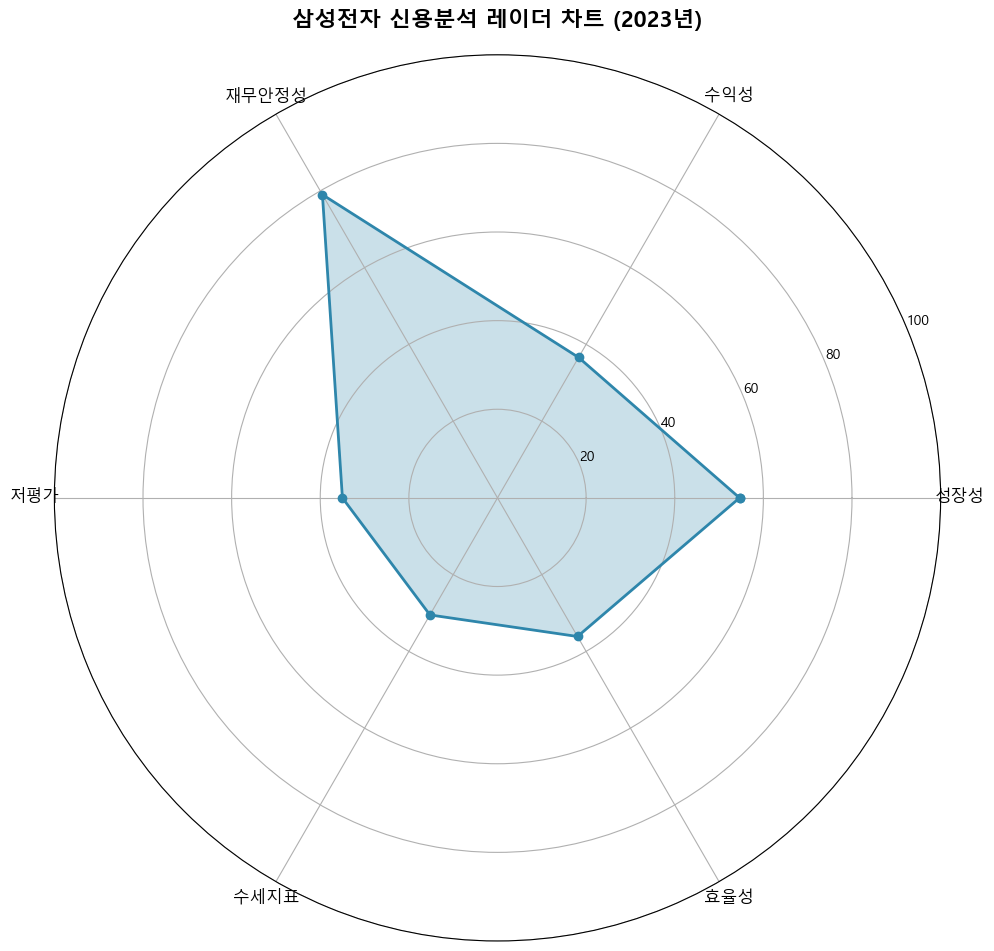

{'summary_card': '## 📘 신용분석 요약 카드\n\n**기업명**: 삼성전자\n**평가일자**: 2023.06.13\n**신용등급**: Aa3/AA- (Stable)\n\n**현재 등급 요약**:\n글로벌 반도체 시장 선도 기업으로 안정적 재무구조와 높은 기술력 인정받은 등급\n\n**주요 강점 키워드**:\n• 글로벌 반도체 점유율 • 탄탄한 재무건전성 • 기술혁신 역량\n\n**주요 리스크 키워드**:\n• 반도체 사이클 변동성 • 글로벌 경쟁 심화 • 지정학적 리스크\n\n**재무 하이라이트**:\n• 매출액: 258조원\n• 영업이익: 15.4조원 (영업이익률 6.0%)\n• ROE: 4.63%\n• 부채비율: 20.98%\n\n**총평**:\n세계적 수준의 기술력과 안정적 재무구조를 바탕으로 높은 신용등급 유지, 미래 성장잠재력 보유',
 'detailed_report': '\n    <!DOCTYPE html>\n    <html lang="ko">\n    <head>\n        <meta charset="UTF-8">\n        <meta name="viewport" content="width=device-width, initial-scale=1.0">\n        <title>삼성전자 신용분석보고서</title>\n        <style>\n            body {\n                font-family: \'Malgun Gothic\', \'Apple SD Gothic Neo\', sans-serif;\n                line-height: 1.6;\n                color: #333;\n                max-width: 1200px;\n                margin: 0 auto;\n                padding: 20px;\n                background-color: #f8f9fa;\n         

In [8]:
await run_single_year_analysis()

🔍 한글 폰트 설치 안내
만약 여전히 한글이 깨진다면:
Windows

시스템에 '맑은 고딕' 폰트가 설치되어 있는지 확인

macOS

기본 시스템 폰트 사용 (별도 설치 불필요)

Linux (Ubuntu/Debian)
bash# 나눔 폰트 설치
sudo apt-get install fonts-nanum

# 또는 Noto CJK 폰트 설치
sudo apt-get install fonts-noto-cjk

# 폰트 캐시 새로고침
fc-cache -fv
이제 한글이 깨지지 않고 깔끔하게 표시될 것입니다! 🎉